In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils
from utils import display_sample_img
import numpy as np

In [49]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils
from tensorflow.keras import backend as K

class BuildModel():
    def __init__(self, img_shape, z_dim, label_dim=None):
        self.img_shape = img_shape
        self.z_dim = z_dim
        self.label_dim = label_dim

    def build_gene(self, activation = 'relu',last_activation='sigmoid', kernel_size=5):
        h, w, ch = self.img_shape
        z = layers.Input(shape=[self.z_dim,], name="noise")
        if self.label_dim:
            c = layers.Input(shape=[self.label_dim,], name='condition')
            y = layers.concatenate([z, c])
            y = layers.Dense(int(w/4)*int(h/4)*128)(y)
        else:
            y = layers.Dense(int(w/4)*int(h/4)*128)(z)
        y = layers.Reshape( [int(w/4),int(h/4),128] )(y)
        y = layers.BatchNormalization()(y)
        y = layers.Conv2DTranspose(64, kernel_size=5, padding='same', strides=2, activation=activation)(y)
        y = layers.BatchNormalization()(y)
        y = layers.Conv2DTranspose(ch, kernel_size=5, padding='same', strides=2, activation=last_activation)(y)
        
        if self.label_dim:
            model = models.Model([z, c], y, name='C_Generator')
        else:
            model = models.Model(z, y, name='Generator')
        return model

    def build_disc(self,activation='relu',last_activation='sigmoid', kernel_size=5):
        h, w, ch = self.img_shape
        x = layers.Input(shape=self.img_shape, name='image')
        
        def _condition_vector(x):
            y = K.expand_dims(x, axis=1)
            y = K.expand_dims(y, axis=1)
            y = K.tile(y, [1, int(h/2), int(w/2), 1])
            return y
        
        if self.label_dim:
            y = layers.Conv2D(64, kernel_size=kernel_size, strides=2, padding='same', activation=activation)(x)
            in_c = layers.Input(shape= self.label_dim, name='condition')
            c = layers.Lambda(_condition_vector)(in_c)
            y = layers.concatenate([y, c], axis=3)
        else:
            y = layers.Conv2D(64, kernel_size=kernel_size, strides=2, padding='same', activation=activation)(x)
        y = layers.Dropout(.5)(y)
        y = layers.Conv2D(128, kernel_size=kernel_size, strides=2, padding='same', activation=activation)(y)
        y = layers.Dropout(.5)(y)
        y = layers.GlobalAveragePooling2D()(y)
        y = layers.Dense(64, activation="relu")(y)
        y = layers.Dense(1, activation=last_activation)(y)
        if self.label_dim:
            model = models.Model([x,in_c], y, name='C_Discriminator')
        else:
            model = models.Model(x, y, name='Discriminator')
        return model

In [71]:
import tensorflow as tf
from tensorflow.keras import models, layers, utils
from utils import display_sample_img
import numpy as np

class GAN():

    def __init__(self, gene, disc, img_shape, noise_dims, label_dims=None):
        self.name = 'GAN'
        self.gene = gene
        self.disc = disc
        self.img_shape = img_shape
        self.noise_dims = noise_dims
        self.label_dims=label_dims
        

    def Compile(self, loss='binary_crossentropy', optimizer='adam'):

        self.disc.compile(loss=loss, optimizer=optimizer)
        self.disc.trainable = False

        input_noise = layers.Input(shape=self.noise_dims)
        if self.label_dims:
            input_label = layers.Input(shape=self.label_dims)
            fake_img = self.gene([input_noise, input_label])
            logit = self.disc([fake_img, input_label])
            self.gan = models.Model([input_noise, input_label], logit, name=self.name)
            self.gan.compile(loss=loss, optimizer=optimizer)
        else:
            fake_img = self.gene(input_noise)
            logit = self.disc(fake_img)
            self.gan = models.Model(input_noise, logit, name=self.name)
            self.gan.compile(loss=loss, optimizer=optimizer)

    def _make_datasets(self, x_data, y_data=None):
        if self.label_dims:
            dataset = tf.data.Dataset.from_tensor_slices((x_data,y_data)).shuffle(1)
        else:
            dataset = tf.data.Dataset.from_tensor_slices(x_data).shuffle(1)
        dataset = dataset.batch(self.batch_size,drop_remainder=True).prefetch(1)
        return dataset

    def _make_constants(self):
        zeros = tf.constant([0.], shape=[self.batch_size, 1])
        ones = tf.constant([1.], shape=[self.batch_size, 1])
        return zeros, ones

    def _make_random(self):
        return tf.random.normal(shape=[self.batch_size, self.noise_dims])
    def _make_random_label(self):
        rnd_labels = np.random.randint(0, self.label_dims, self.batch_size)
        rnd_labels = utils.to_categorical(rnd_labels, self.label_dims)
        return rnd_labels

    def fit(self, x_data, y_data=None, epochs=1, batch_size=32, standard=False):

        # setting
        self.batch_size = batch_size
        if self.label_dims:
            train_ds = self._make_datasets(x_data, y_data)
            seed_noises = tf.random.normal(shape=[30, self.noise_dims])
            seed_labels =  np.tile(utils.to_categorical(np.arange(10), 10), (3,1))
        else:
            train_ds = self._make_datasets(x_data)
        zeros, ones = self._make_constants()

        # train
        history = {'d_loss': [], 'g_loss': []}
        for epoch in range(1 + epochs):
            if epoch > 0:
                for h in history:
                    history[h].append(0)
                
                if self.label_dims:
                    for real_imgs , real_labels in train_ds:
                        # phase 1 - training the discriminator
                        fake_imgs = self.gene.predict_on_batch( [self._make_random(), real_labels ])

                        self.disc.trainable = True
                        d_loss_real = self.disc.train_on_batch([real_imgs, real_labels], ones)
                        d_loss_fake = self.disc.train_on_batch([fake_imgs, real_labels], zeros)
                        d_loss = (0.5 * d_loss_real) + (0.5 * d_loss_fake)

                        # phase 2 - training the generator
                        self.disc.trainable = False
                        g_loss = self.gan.train_on_batch([self._make_random(), self._make_random_label()], ones)

                        history['d_loss'][-1] += d_loss
                        history['g_loss'][-1] += g_loss

                    # end 1 epoch
                    print('* epoch: %i, d_loss: %f, g_loss: %f' %
                          (epoch, history['d_loss'][-1], history['g_loss'][-1]))
                    fake_imgs = self.gene.predict([seed_noises, seed_labels])
                    display_sample_img(fake_imgs, (3, 10), standard=standard, size=2)
                else:
                    for real_imgs in train_ds:
                        # phase 1 - training the discriminator
                        fake_imgs = self.gene.predict_on_batch(self._make_random())

                        self.disc.trainable = True
                        d_loss_real = self.disc.train_on_batch(real_imgs, ones)
                        d_loss_fake = self.disc.train_on_batch(fake_imgs, zeros)
                        d_loss = (0.5 * d_loss_real) + (0.5 * d_loss_fake)

                        # phase 2 - training the generator
                        self.disc.trainable = False
                        g_loss = self.gan.train_on_batch(self._make_random(), ones)

                        history['d_loss'][-1] += d_loss
                        history['g_loss'][-1] += g_loss

                    # end 1 epoch
                    print('* epoch: %i, d_loss: %f, g_loss: %f' %
                          (epoch, history['d_loss'][-1], history['g_loss'][-1]))
                    fake_imgs = self.gene.predict(self._make_random())
                    display_sample_img(fake_imgs, (2, 8), standard=standard, size=2)

In [72]:
IMG_SHAPE = (28,28,1)
NOISE_DIM = 128
LABEL_DIM = 10

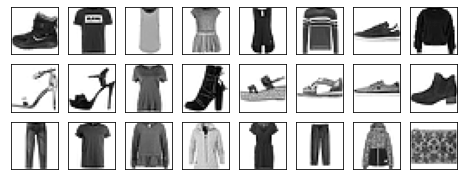

((60000, 28, 28, 1), (60000, 10), (10000, 28, 28), (10000, 10))

In [73]:
from data_loader import *
from utils import display_sample_img
x_train, y_train, x_test, y_test = fmnist_loader(True, True)
display_sample_img(x_train, (3,8), True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# 이미지 -1~1 제너레이터가 -1~1까지의 이미지를 생성해야한다.

In [74]:
builder = BuildModel(IMG_SHAPE, NOISE_DIM, label_dim=10)
gene = builder.build_gene(last_activation='tanh') # tanh : -1 ~ 1 아웃풋  sigmoid: 0~1 아웃풋
disc = builder.build_disc()
gene.summary()
disc.summary()

Model: "C_Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 noise (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 condition (InputLayer)         [(None, 10)]         0           []                               
                                                                                                  
 concatenate_23 (Concatenate)   (None, 138)          0           ['noise[0][0]',                  
                                                                  'condition[0][0]']              
                                                                                                  
 dense_31 (Dense)               (None, 6272)         871808      ['concatenate_23[0][0]'

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 C_Generator (Functional)       (None, 28, 28, 1)    1079041     ['input_15[0][0]',               
                                                                  'input_16[0][0]']               
                                                                                                  
 C_Discriminator (Functional)   (None, 1)            246913      ['C_Generator[0][0]',          

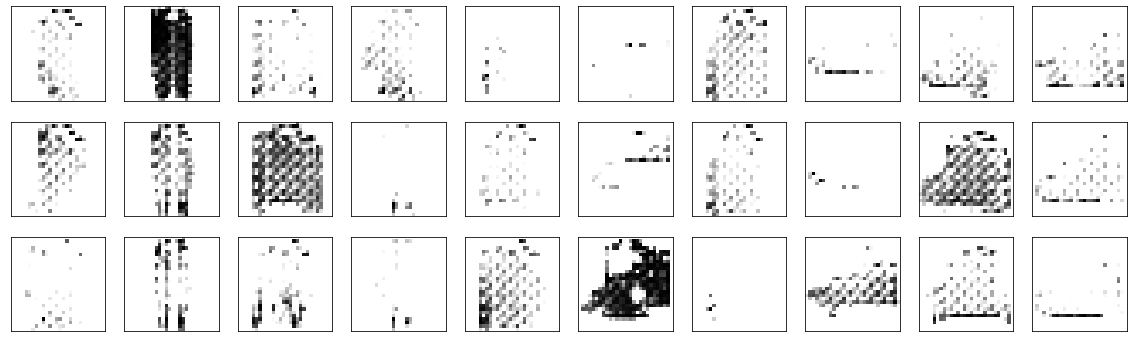

* epoch: 2, d_loss: 725.489501, g_loss: 3700.475909
1/1 [==============================] - 0s 13ms/step


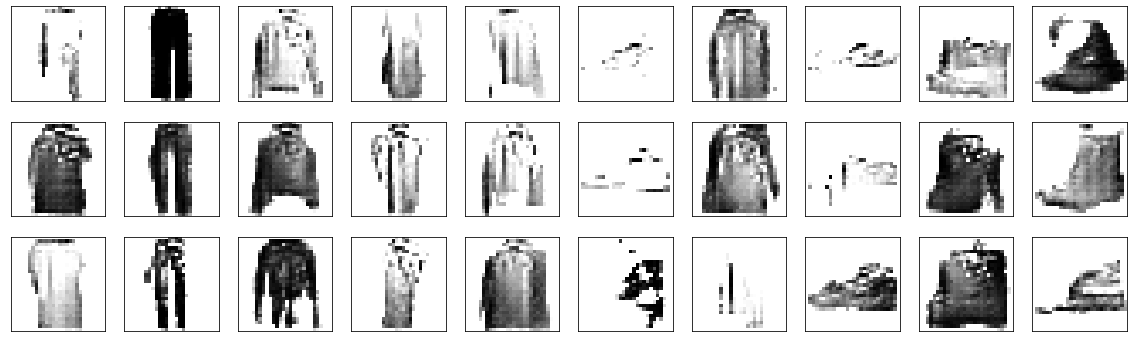

* epoch: 3, d_loss: 721.183302, g_loss: 3721.266143
1/1 [==============================] - 0s 14ms/step


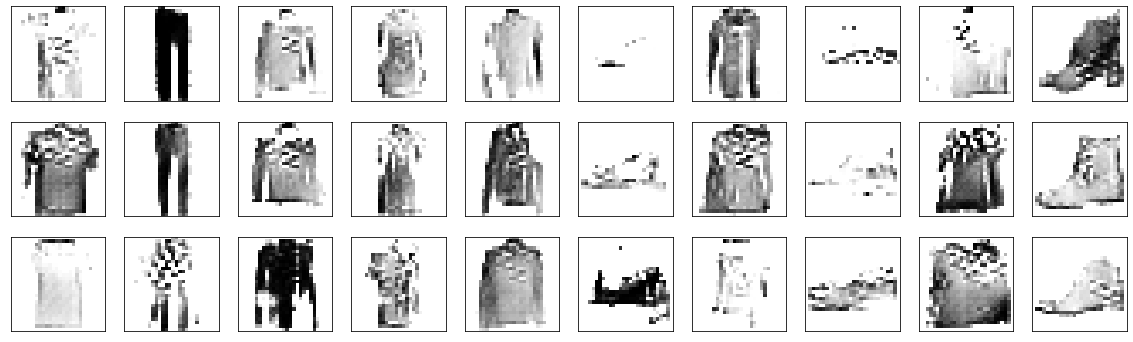

* epoch: 4, d_loss: 897.455554, g_loss: 2819.127407
1/1 [==============================] - 0s 13ms/step


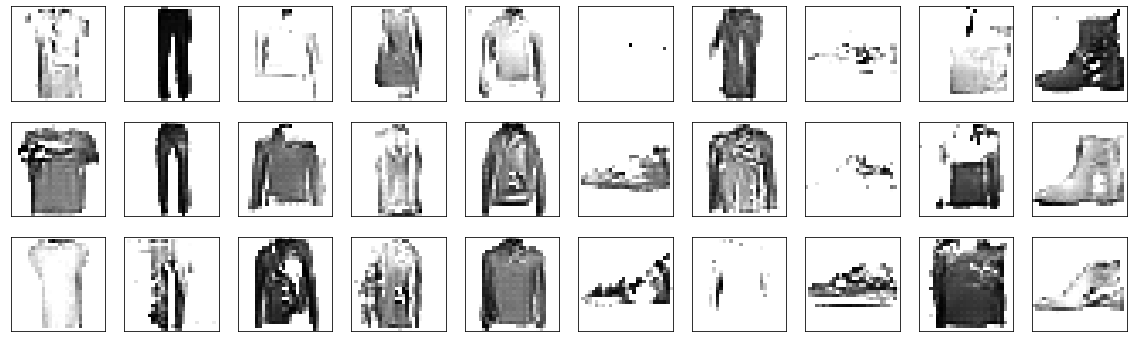

* epoch: 5, d_loss: 924.641643, g_loss: 2686.795892
1/1 [==============================] - 0s 14ms/step


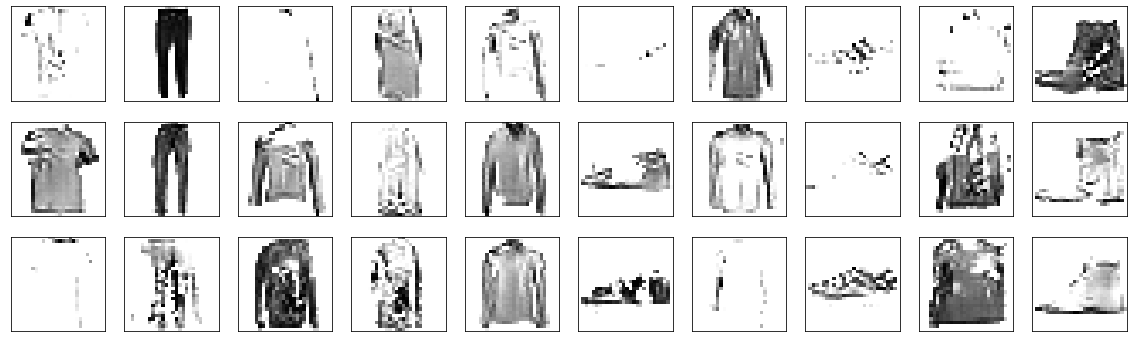

In [75]:
model = GAN(gene, disc, IMG_SHAPE, NOISE_DIM,LABEL_DIM)
model.Compile()
model.gan.summary()
model.fit(x_train,y_train,  epochs= 5)

* epoch: 1, d_loss: 910.834388, g_loss: 2743.920136
1/1 [==============================] - 0s 13ms/step


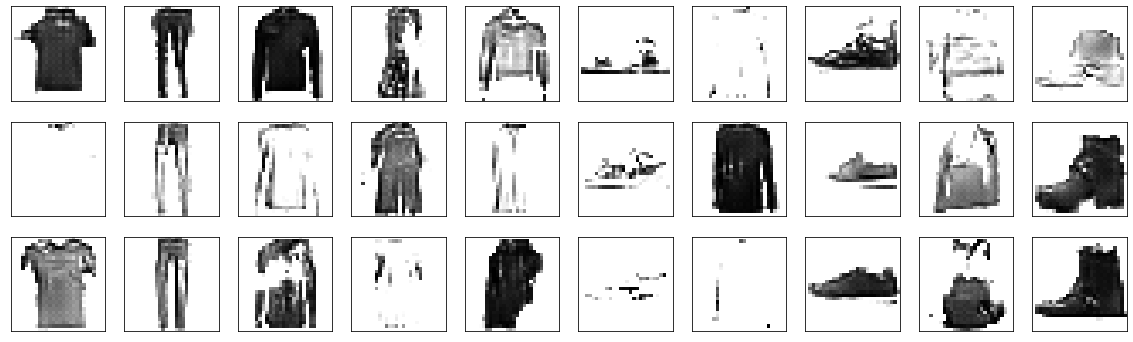

* epoch: 2, d_loss: 915.673211, g_loss: 2706.722388
1/1 [==============================] - 0s 13ms/step


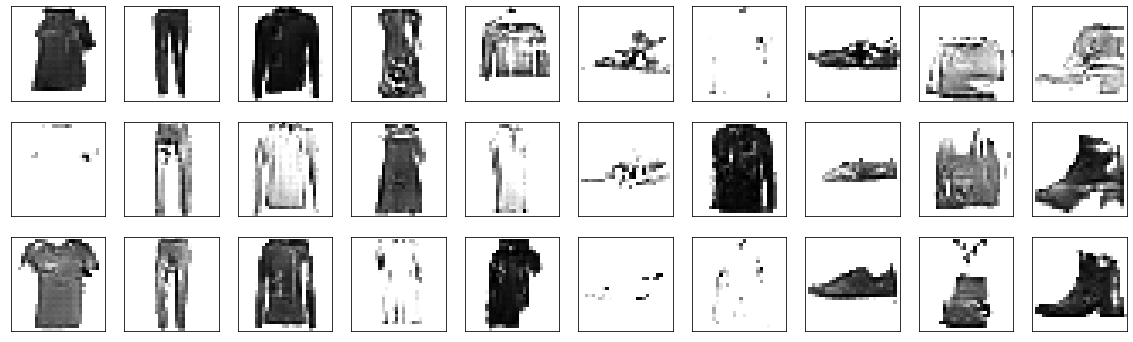

* epoch: 3, d_loss: 904.340625, g_loss: 2746.351012
1/1 [==============================] - 0s 14ms/step


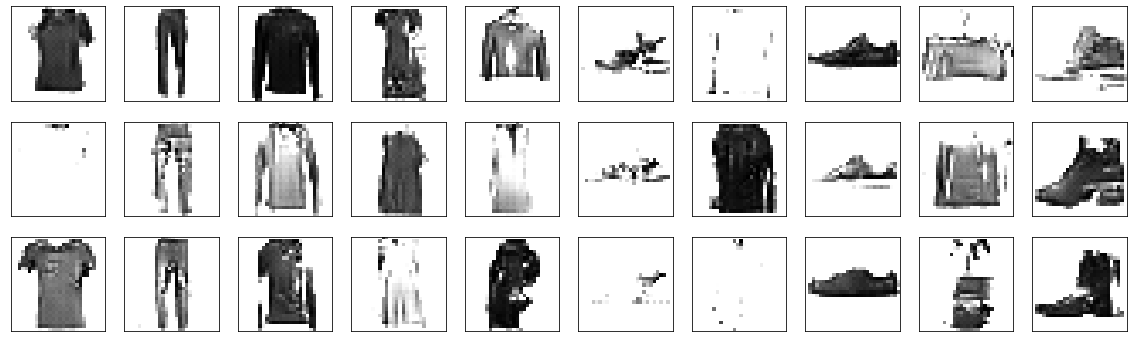

* epoch: 4, d_loss: 902.543052, g_loss: 2768.065592
1/1 [==============================] - 0s 13ms/step


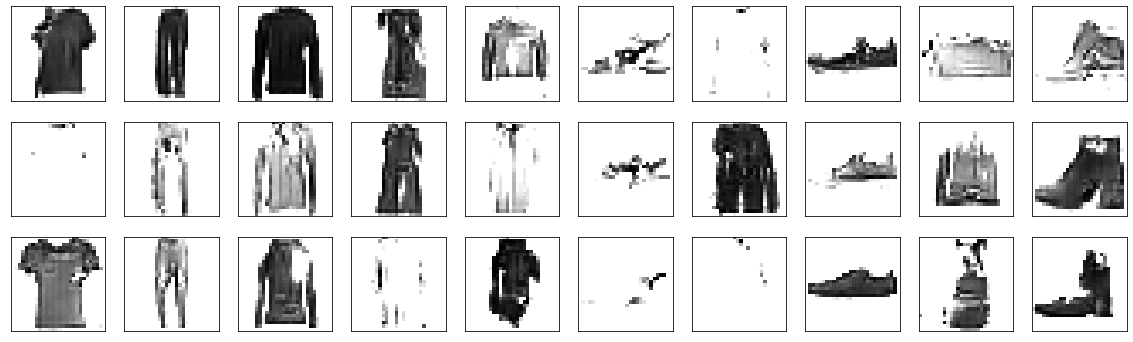

* epoch: 5, d_loss: 909.595760, g_loss: 2698.257196
1/1 [==============================] - 0s 14ms/step


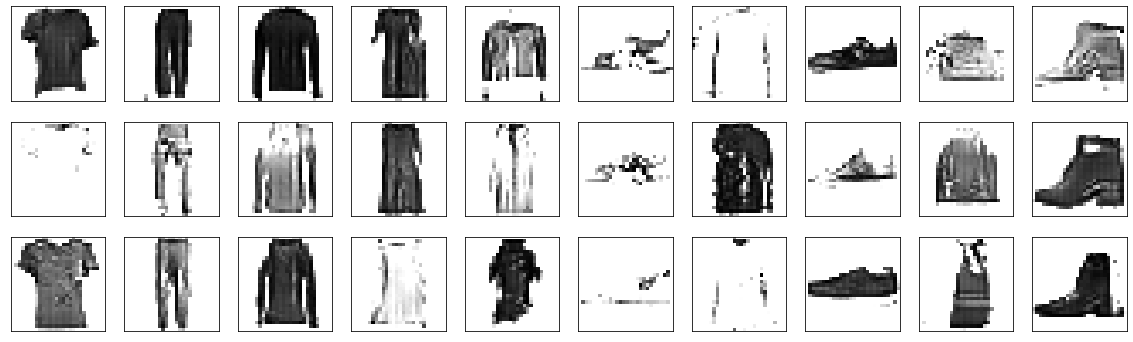

In [76]:
model.fit(x_train,y_train,  epochs= 5)